In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from scipy.stats import entropy

In [52]:
# Load the data
df_pbs = pd.read_csv('../pbs_c/cmake-build-debug/pbsBlocks.csv')
df_cmp = pd.read_csv('../pbs_c/cmake-build-debug/comparison.csv')

In [53]:
df_pbs.describe()

,Block Number,Proposer ID,Builder ID,Winning Bid Value,Winning Block Value,Reward,Builder ID 1 Bid,Builder ID 2 Bid,Builder ID 3 Bid,Builder ID 4 Bid,...,Builder ID 1 Block Value,Builder ID 2 Block Value,Builder ID 3 Block Value,Builder ID 4 Block Value,Builder ID 5 Block Value,Builder ID 10 Block Value,Builder ID 30 Block Value,Builder ID 50 Block Value,Builder ID 70 Block Value,Builder ID 90 Block Value
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,26.715400,49.015000,441.741816,500.060756,210.034683,52.467774,67.455590,35.568510,55.436672,...,280.517483,304.384979,255.986667,288.189966,283.966026,347.717420,332.454775,346.033172,343.739026,491.496752
std,1443.520003,31.009959,36.687327,100.680668,120.750660,195.564980,130.326146,145.848784,108.078422,133.125243,...,123.257442,129.042645,117.814832,127.535000,125.796165,131.135766,131.185373,136.168080,131.153696,134.109371
min,1.000000,1.000000,1.000000,20.897500,20.897500,0.007527,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.750000,3.000000,10.000000,390.280250,441.067000,48.058875,0.000000,0.000000,0.000000,0.000000,...,189.797250,211.761500,169.970000,195.082750,193.671500,256.864500,240.738250,251.096250,255.002250,402.004750
50%,2500.500000,10.000000,50.000000,453.176000,507.947000,128.948500,0.000000,0.000000,0.000000,0.000000,...,274.083000,299.383000,248.265500,282.917000,278.518500,352.593500,333.603000,348.103000,344.666500,491.301000
75%,3750.250000,50.000000,90.000000,500.906000,572.494250,369.806750,0.000000,0.000000,0.000000,0.000000,...,361.041750,388.884000,333.094000,375.908500,369.763250,438.343500,426.722750,440.046250,434.812250,582.788750
max,5000.000000,90.000000,90.000000,899.877000,921.448000,899.877000,575.076000,657.357000,570.005000,596.772000,...,738.350000,794.225000,665.567000,766.151000,771.050000,804.520000,730.867000,843.693000,772.007000,932.778000


In [54]:
def get_builder_type(id):
    if 1 <= id <= 9:
        return 'Normal Proposer Builder'
    elif 10 <= id <= 999:
        return 'MEV Proposer Builder'
    else:
        return 'Unknown Builder'

def adjust_builder_id(id):
    if(get_builder_type(id) == 'MEV Proposer Builder'):
        return int(int(id) / 20 + 1)
    else:
        return id

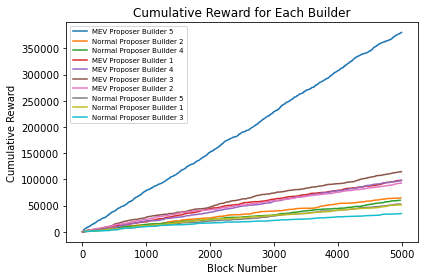

In [55]:
builder_ids = df_pbs['Builder ID'].unique()
fig, axs = plt.subplots()
for builder_id in builder_ids:
    builder_df_pbs = df_pbs[df_pbs['Builder ID'] == builder_id]
    cumulative_rewards = np.cumsum([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id])
    axs.plot(builder_df_pbs['Block Number'].values, cumulative_rewards, label=f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}')

axs.set_title('Cumulative Reward for Each Builder')
axs.set_xlabel('Block Number')
axs.set_ylabel('Cumulative Reward')
axs.legend(loc='best',prop={'size': 7})
plt.tight_layout()
plt.show()

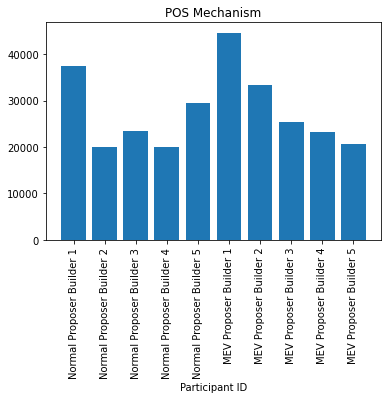

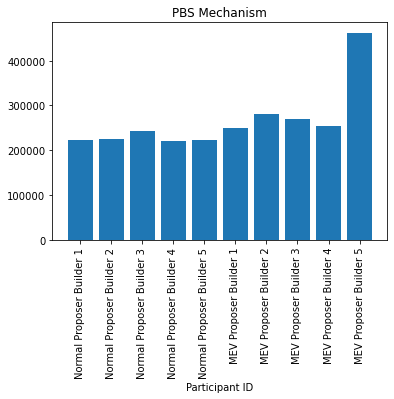

In [56]:
total_rewards_pos = []
total_rewards_pbs = []
builder_ids = np.sort(df_pbs['Builder ID'].unique())

for builder_id in builder_ids:
    cumulative_rewards_pbs = ([reward for reward, id, b_id in zip(df_pbs['Reward'], df_pbs['Builder ID'],df_pbs['Proposer ID']) if id == builder_id & id != b_id]+
                             [bid for bid, id in zip(df_pbs['Winning Bid Value'], df_pbs['Proposer ID']) if id == builder_id])
    total_rewards_pbs.append(sum(cumulative_rewards_pbs))

    cumulative_rewards_pos = [reward for reward, id in zip(df_cmp['POS Block Value'], df_cmp['POS Builder ID']) if id == builder_id]
    total_rewards_pos.append(sum(cumulative_rewards_pos))


builder_labels = [f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}' for builder_id in builder_ids]
plt.bar(builder_labels, total_rewards_pos)
plt.title('POS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()

plt.bar(builder_labels, total_rewards_pbs)
plt.title('PBS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()



In [57]:
def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [58]:
#this is for homogenous builders, 5 extra nodes, 10000 blocks. 
gini_pbs = gini(np.array(total_rewards_pbs))
gini_pos = gini(np.array(total_rewards_pos))

print(f'Gini coefficient for PBS rewards: {gini_pbs}')
print(f'Gini coefficient for POS rewards: {gini_pos}')

Gini coefficient for PBS rewards: 0.10914062169708223
Gini coefficient for POS rewards: 0.154026755831973


In [59]:
# Herfindahl-Hirschman Index (HHI) 
def hhi(x):
    """Compute Herfindahl-Hirschman Index of array of values"""
    return (x**2).sum() / (x.sum())**2

hhi_pos = hhi(np.array(total_rewards_pos))
hhi_pbs = hhi(np.array(total_rewards_pbs))

print(f"HHI for PBS: {hhi_pbs}")
print(f"HHI for POS: {hhi_pos}")

HHI for PBS: 0.10669752683505347
HHI for POS: 0.10813496071221117


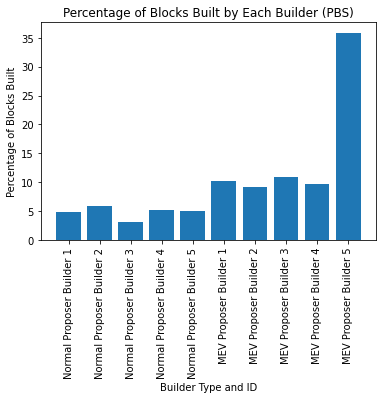

In [60]:
block_counts = [len(df_pbs[df_pbs['Builder ID'] == builder_id]) for builder_id in builder_ids]
block_percentages = [count / len(df_pbs) * 100 for count in block_counts]

plt.bar(builder_labels, block_percentages)
plt.title('Percentage of Blocks Built by Each Builder (PBS)')
plt.xlabel('Builder Type and ID')
plt.ylabel('Percentage of Blocks Built')
# Rotate the x-axis labels
plt.xticks(rotation=90) 
plt.show()
